**handson用資料としての注意点**

普通、同じセル上で何度も試行錯誤するので、最終的に上手くいったセルしか残らず、失敗したセルは残りませんし、わざわざ残しません。

今回はhandson用に 試行・思考過程を残したいと思い、エラーやミスが出ても下のセルに進んで処理を実行するようにしています。

notebookのセル単位の実行ができるからこそのやり方かもしれません。良い。

（下のセルから文は常体で書きます。）

kunai (@jdgthjdg)

---


# ここまでの処理を整理して、2008〜2019のデータを繋いでみる

## xls,xlsxファイルを漁る

In [1]:
from pathlib import Path

In [2]:
base_dir = Path("../../../data")
base_dir.exists()

True

In [3]:
list(base_dir.glob("*_kansai/*"))

[PosixPath('../../../data/2010_kansai/ë╘ò▓âfü[â^2010(è╓É╝).xls'),
 PosixPath('../../../data/2010_kansai/AMeDAS2010(è╓É╝).xls'),
 PosixPath('../../../data/2017_kansai/ë╘ò▓âfü[â^2017(è╓É╝).xlsx'),
 PosixPath('../../../data/2017_kansai/AMeDAS2017(è╓É╝).xlsx'),
 PosixPath('../../../data/2015_kansai/AMeDAS2015(è╓É╝).xlsx'),
 PosixPath('../../../data/2015_kansai/ë╘ò▓âfü[â^2015(è╓É╝).xlsx'),
 PosixPath('../../../data/2009_kansai/AMeDAS2009(è╓É╝).xls'),
 PosixPath('../../../data/2009_kansai/ë╘ò▓âfü[â^2009(è╓É╝).xls'),
 PosixPath('../../../data/2014_kansai/AMeDAS2014(è╓É╝).xls'),
 PosixPath('../../../data/2014_kansai/ë╘ò▓âfü[â^2014(è╓É╝).xls'),
 PosixPath('../../../data/2012_kansai/AMeDAS2012(è╓É╝).xls'),
 PosixPath('../../../data/2012_kansai/ë╘ò▓âfü[â^2012(è╓É╝).xls'),
 PosixPath('../../../data/2008_kansai/.Rhistory'),
 PosixPath('../../../data/2008_kansai/ë╘ò▓âfü[â^2008(è╓É╝).xls'),
 PosixPath('../../../data/2008_kansai/AMeDAS2008(è╓É╝).xls'),
 PosixPath('../../../data/2016_kansai/AMeDAS2016(

In [4]:
p = list(base_dir.glob("*_kansai/*"))[0]
p.name

'ë╘ò▓âfü[â^2010(è╓É╝).xls'

In [5]:
kansai_kafun_files = []
for p in base_dir.glob("*_kansai/*"):
    # AMeDASだけ弾く
    if not p.name.startswith("AMeDAS"):
        kansai_kafun_files.append(p)
kansai_kafun_files

[PosixPath('../../../data/2010_kansai/ë╘ò▓âfü[â^2010(è╓É╝).xls'),
 PosixPath('../../../data/2017_kansai/ë╘ò▓âfü[â^2017(è╓É╝).xlsx'),
 PosixPath('../../../data/2015_kansai/ë╘ò▓âfü[â^2015(è╓É╝).xlsx'),
 PosixPath('../../../data/2009_kansai/ë╘ò▓âfü[â^2009(è╓É╝).xls'),
 PosixPath('../../../data/2014_kansai/ë╘ò▓âfü[â^2014(è╓É╝).xls'),
 PosixPath('../../../data/2012_kansai/ë╘ò▓âfü[â^2012(è╓É╝).xls'),
 PosixPath('../../../data/2008_kansai/.Rhistory'),
 PosixPath('../../../data/2008_kansai/ë╘ò▓âfü[â^2008(è╓É╝).xls'),
 PosixPath('../../../data/2016_kansai/ë╘ò▓âfü[â^2016(è╓É╝).xlsx'),
 PosixPath('../../../data/2018_kansai/ë╘ò▓âfü[â^2018(è╓É╝).xlsx'),
 PosixPath('../../../data/2011_kansai/ë╘ò▓âfü[â^2011(è╓É╝).xls'),
 PosixPath('../../../data/2013_kansai/ë╘ò▓âfü[â^2013(è╓É╝).xls')]

lock ファイルが混じってしまった。<BR>
AMeDASだけ弾くと .lockファイルも入ってしまうので、<br>
試しに **読めない文字 ( ë╘ò▓âfü[â )** で引っ掛けてみる

In [6]:
kansai_kafun_files = []
for p in base_dir.glob("*_kansai/*"):
    # AMeDASだけ弾くと .lockファイルも入ってしまうので、読めない謎の文字で引っ掛けてみる
    if p.name.startswith("ë╘ò▓âfü[â"):
        kansai_kafun_files.append(p)
kansai_kafun_files

[PosixPath('../../../data/2010_kansai/ë╘ò▓âfü[â^2010(è╓É╝).xls'),
 PosixPath('../../../data/2017_kansai/ë╘ò▓âfü[â^2017(è╓É╝).xlsx'),
 PosixPath('../../../data/2015_kansai/ë╘ò▓âfü[â^2015(è╓É╝).xlsx'),
 PosixPath('../../../data/2009_kansai/ë╘ò▓âfü[â^2009(è╓É╝).xls'),
 PosixPath('../../../data/2014_kansai/ë╘ò▓âfü[â^2014(è╓É╝).xls'),
 PosixPath('../../../data/2012_kansai/ë╘ò▓âfü[â^2012(è╓É╝).xls'),
 PosixPath('../../../data/2008_kansai/ë╘ò▓âfü[â^2008(è╓É╝).xls'),
 PosixPath('../../../data/2016_kansai/ë╘ò▓âfü[â^2016(è╓É╝).xlsx'),
 PosixPath('../../../data/2018_kansai/ë╘ò▓âfü[â^2018(è╓É╝).xlsx'),
 PosixPath('../../../data/2011_kansai/ë╘ò▓âfü[â^2011(è╓É╝).xls'),
 PosixPath('../../../data/2013_kansai/ë╘ò▓âfü[â^2013(è╓É╝).xls')]

いけた

ソートしてもいいけど、どのみち日付データはとるのでこのまま

---

# 今までの処理を適用していく

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
#設定でDataFrameなどが長く表示されないようにします（画面領域の消費を抑えてhandsonをしやすくするため）
# 長い場合の途中の省略表示(...)を出す閾値の設定（折り返しとは無関係）
pd.set_option('max_rows',10)
pd.set_option('max_columns',20) # これを超えたら全部は表示しない。 A B C ... X Y Z のように途中を省く。

In [8]:
p = kansai_kafun_files[-1]
print(p) # for の残りかす
df = pd.read_excel(p, skiprows=1).iloc[:,:-2]
df

../../../data/2013_kansai/ë╘ò▓âfü[â^2013(è╓É╝).xls


,年,月,日,時,彦根,大津,今津,野洲,京都,舞鶴,...,神戸,西宮,篠山,西播磨,奈良,吉野,大和高田,和歌山,田辺,中辺路
0,2013,2,1,1,4.0,0.0,0.0,0.0,4.0,0.0,...,0.0,0.0,0.0,0.0,4.0,0.0,8.0,4.0,0.0,0.0
1,2013,2,1,2,8.0,0.0,4.0,0.0,0.0,0.0,...,8.0,0.0,8.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0
2,2013,2,1,3,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,0.0,4.0,0.0,8.0,0.0,4.0,4.0,0.0,0.0
3,2013,2,1,4,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2013,2,1,5,0.0,0.0,0.0,0.0,0.0,0.0,...,12.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3595,2013,6,30,20,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3596,2013,6,30,21,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3597,2013,6,30,22,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3598,2013,6,30,23,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
str_concat_h0_23 = df["年"].astype(str)+"/"+df["月"].astype(str)+"/"+df["日"].astype(str)+"/"+(df["時"]-1).astype(str) # 時から1引いてる
df["date_hour"] = pd.to_datetime(str_concat_h0_23, format="%Y/%m/%d/%H")
df.set_index("date_hour", inplace=True)
df = df.drop(columns=["年","月","日","時",]) # こっちでも全然良い
df

,彦根,大津,今津,野洲,京都,舞鶴,京北,大阪,豊中,河内長野,神戸,西宮,篠山,西播磨,奈良,吉野,大和高田,和歌山,田辺,中辺路
date_hour,,,,,,,,,,,,,,,,,,,,
2013-02-01 00:00:00,4.0,0.0,0.0,0.0,4.0,0.0,0.0,8.0,4.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,8.0,4.0,0.0,0.0
2013-02-01 01:00:00,8.0,0.0,4.0,0.0,0.0,0.0,0.0,4.0,8.0,4.0,8.0,0.0,8.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0
2013-02-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,4.0,0.0,4.0,0.0,8.0,0.0,4.0,4.0,0.0,0.0
2013-02-01 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-02-01 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,12.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-06-30 19:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-06-30 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-06-30 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# ここまでを関数にする

多くの試行錯誤があったがこれだけのコードに圧縮された・・・

In [10]:
def load_kafun_excel(path):
    df = pd.read_excel(path, skiprows=1).iloc[:,:-2]
    str_concat_h0_23 = df["年"].astype(str)+"/"+df["月"].astype(str)+"/"+df["日"].astype(str)+"/"+(df["時"]-1).astype(str) # 時から1引いてる
    df["date_hour"] = pd.to_datetime(str_concat_h0_23, format="%Y/%m/%d/%H")
    df.set_index("date_hour", inplace=True)
    df = df.drop(columns=["年","月","日","時",]) # こっちでも全然良い
    return df

In [11]:
load_kafun_excel(p)

,彦根,大津,今津,野洲,京都,舞鶴,京北,大阪,豊中,河内長野,神戸,西宮,篠山,西播磨,奈良,吉野,大和高田,和歌山,田辺,中辺路
date_hour,,,,,,,,,,,,,,,,,,,,
2013-02-01 00:00:00,4.0,0.0,0.0,0.0,4.0,0.0,0.0,8.0,4.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,8.0,4.0,0.0,0.0
2013-02-01 01:00:00,8.0,0.0,4.0,0.0,0.0,0.0,0.0,4.0,8.0,4.0,8.0,0.0,8.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0
2013-02-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,4.0,0.0,4.0,0.0,8.0,0.0,4.0,4.0,0.0,0.0
2013-02-01 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-02-01 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,12.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-06-30 19:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-06-30 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-06-30 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## for文で回す 安心の有限

In [12]:
kafun_df_list = []
for p in kansai_kafun_files:
    df = load_kafun_excel(p)
    kafun_df_list.append(df)

In [13]:
kafun_df_list[0]

,彦根,大津,今津,野洲,京都,舞鶴,京北,大阪,豊中,河内長野,神戸,西宮,篠山,山崎,奈良,吉野,大和高田,和歌山,田辺,中辺路
date_hour,,,,,,,,,,,,,,,,,,,,
2010-02-01 00:00:00,0.0,0.0,0.0,0.0,0.0,12.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,4.0
2010-02-01 01:00:00,0.0,0.0,0.0,0.0,4.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0
2010-02-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0
2010-02-01 03:00:00,4.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0
2010-02-01 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-05-31 19:00:00,12.0,8.0,NaN,NaN,8.0,0.0,NaN,4.0,4.0,0.0,4.0,4.0,0.0,16.0,0.0,28.0,0.0,0.0,0,4.0
2010-05-31 20:00:00,16.0,4.0,NaN,NaN,4.0,4.0,NaN,12.0,0.0,0.0,8.0,4.0,0.0,8.0,4.0,16.0,4.0,0.0,0,0.0
2010-05-31 21:00:00,0.0,4.0,NaN,NaN,4.0,4.0,NaN,8.0,4.0,0.0,0.0,8.0,0.0,4.0,8.0,8.0,4.0,8.0,0,0.0


# リスト内のdfを行方向(縦方向, y方向)に連結する

**[pd.concat](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.concat.html)**

df の連結/結合/マージ  
http://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html


In [14]:
kafun = pd.concat(kafun_df_list, axis=1)
kafun.shape

(36792, 219)

In [15]:
kafun.columns

Index(['彦根', '大津', '今津', '野洲', '京都', '舞鶴', '京北', '大阪', '豊中', '河内長野',
       ...
       '神戸', '西宮', '篠山', '西播磨', '奈良', '吉野', '大和高田', '和歌山', '田辺', '中辺路'],
      dtype='object', length=219)

<br>
ミスってcolumnsの数が成長した。横方向につながっている  
<br>
<br>

In [16]:
kafun = pd.concat(kafun_df_list, axis=0)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


warning された。 今後ソートしないとのこと

In [17]:
kafun = pd.concat(kafun_df_list, axis=0, sort=False)
kafun.shape

(36792, 46)

このaxis方向でも columns が倍くらいに増えている・・・

In [18]:
kafun.columns

Index(['彦根', '大津', '今津', '野洲', '京都', '舞鶴', '京北', '大阪', '豊中', '河内長野', '神戸',
       '西宮', '篠山', '山崎', '奈良', '吉野', '大和高田', '和歌山', '田辺', '中辺路', '彦根市役所',
       '滋賀県琵琶湖・環境科学研究センター', '滋賀県高島合同庁舎', '滋賀県林業普及センター', '京都府立医科大学',
       '京都府中丹東保健所', '京都市右京区役所京北合同庁舎', '大阪合同庁舎第2号館別館', '豊中市役所第一庁舎', '泉大津市役所',
       '兵庫県立健康環境科学研究センター', '北山緑化植物園', '兵庫県篠山庁舎', '西播磨県民局西播磨総合庁舎',
       '奈良県産業振興総合センター', '奈良県吉野保健所', '橿原総合庁舎', '和歌山地方気象台', '和歌山県西牟婁振興局庁舎',
       '和歌山県東牟婁振興局', '滋賀県森林センター', '大阪府環境農林水産総合研究所', '西播磨', '彦根地方気象台',
       '舞鶴市西ｺﾐｭﾆﾃｨｾﾝﾀｰ', '兵庫県環境研究センター'],
      dtype='object')

恐らく年が変わった時に列の名前が変わったようだ（多分担当者も）   
データのフォーマットが変わると、恐ろしく面倒なことが起きる・・・

In [19]:
kafun_df_list[0].columns

Index(['彦根', '大津', '今津', '野洲', '京都', '舞鶴', '京北', '大阪', '豊中', '河内長野', '神戸',
       '西宮', '篠山', '山崎', '奈良', '吉野', '大和高田', '和歌山', '田辺', '中辺路'],
      dtype='object')

In [20]:
kafun_df_list[1].columns

Index(['彦根市役所', '滋賀県琵琶湖・環境科学研究センター', '滋賀県高島合同庁舎', '滋賀県林業普及センター', '京都府立医科大学',
       '京都府中丹東保健所', '京都市右京区役所京北合同庁舎', '大阪合同庁舎第2号館別館', '豊中市役所第一庁舎', '泉大津市役所',
       '兵庫県立健康環境科学研究センター', '北山緑化植物園', '兵庫県篠山庁舎', '西播磨県民局西播磨総合庁舎',
       '奈良県産業振興総合センター', '奈良県吉野保健所', '橿原総合庁舎', '和歌山地方気象台', '和歌山県西牟婁振興局庁舎',
       '和歌山県東牟婁振興局'],
      dtype='object')

# 想像以上に全然違う・・・

ファイル名をみる

In [21]:
kansai_kafun_files[0].name

'ë╘ò▓âfü[â^2010(è╓É╝).xls'

In [22]:
kansai_kafun_files[1].name

'ë╘ò▓âfü[â^2017(è╓É╝).xlsx'

xlsとxlsxの頃から変わったのかも？　とりあえず ロードした時にcolumnsを表示する雑な関数を作って試す

In [23]:
def show_columns(path):
    df = pd.read_excel(path, skiprows=1).iloc[:,:-2]
    return df.columns

In [24]:
for p in kansai_kafun_files:
    print(p, show_columns(p))

../../../data/2010_kansai/ë╘ò▓âfü[â^2010(è╓É╝).xls Index(['年', '月', '日', '時', '彦根', '大津', '今津', '野洲', '京都', '舞鶴', '京北', '大阪',
       '豊中', '河内長野', '神戸', '西宮', '篠山', '山崎', '奈良', '吉野', '大和高田', '和歌山', '田辺',
       '中辺路'],
      dtype='object')
../../../data/2017_kansai/ë╘ò▓âfü[â^2017(è╓É╝).xlsx Index(['年', '月', '日', '時', '彦根市役所', '滋賀県琵琶湖・環境科学研究センター', '滋賀県高島合同庁舎',
       '滋賀県林業普及センター', '京都府立医科大学', '京都府中丹東保健所', '京都市右京区役所京北合同庁舎',
       '大阪合同庁舎第2号館別館', '豊中市役所第一庁舎', '泉大津市役所', '兵庫県立健康環境科学研究センター', '北山緑化植物園',
       '兵庫県篠山庁舎', '西播磨県民局西播磨総合庁舎', '奈良県産業振興総合センター', '奈良県吉野保健所', '橿原総合庁舎',
       '和歌山地方気象台', '和歌山県西牟婁振興局庁舎', '和歌山県東牟婁振興局'],
      dtype='object')
../../../data/2015_kansai/ë╘ò▓âfü[â^2015(è╓É╝).xlsx Index(['年', '月', '日', '時', '彦根市役所', '滋賀県琵琶湖・環境科学研究センター', '滋賀県高島合同庁舎',
       '滋賀県森林センター', '京都府立医科大学', '京都府中丹東保健所', '京都市右京区役所京北合同庁舎',
       '大阪府環境農林水産総合研究所', '豊中市役所第一庁舎', '泉大津市役所', '兵庫県立健康環境科学研究センター', '北山緑化植物園',
       '兵庫県篠山庁舎', '西播磨県民局西播磨総合庁舎', '奈良県産業振興総合センター', '奈良県吉野保健所', '橿原総合庁舎',
       '和歌山

<br>
年が順不同で見にくいので結局ソートしてみる

In [25]:
sorted(kansai_kafun_files) 

[PosixPath('../../../data/2008_kansai/ë╘ò▓âfü[â^2008(è╓É╝).xls'),
 PosixPath('../../../data/2009_kansai/ë╘ò▓âfü[â^2009(è╓É╝).xls'),
 PosixPath('../../../data/2010_kansai/ë╘ò▓âfü[â^2010(è╓É╝).xls'),
 PosixPath('../../../data/2011_kansai/ë╘ò▓âfü[â^2011(è╓É╝).xls'),
 PosixPath('../../../data/2012_kansai/ë╘ò▓âfü[â^2012(è╓É╝).xls'),
 PosixPath('../../../data/2013_kansai/ë╘ò▓âfü[â^2013(è╓É╝).xls'),
 PosixPath('../../../data/2014_kansai/ë╘ò▓âfü[â^2014(è╓É╝).xls'),
 PosixPath('../../../data/2015_kansai/ë╘ò▓âfü[â^2015(è╓É╝).xlsx'),
 PosixPath('../../../data/2016_kansai/ë╘ò▓âfü[â^2016(è╓É╝).xlsx'),
 PosixPath('../../../data/2017_kansai/ë╘ò▓âfü[â^2017(è╓É╝).xlsx'),
 PosixPath('../../../data/2018_kansai/ë╘ò▓âfü[â^2018(è╓É╝).xlsx')]

---
**もしソートがうまくいかないパスだったら sorted の key=を設定する**

In [26]:
p.name[10:14]  # ファイル名から年を抜き出すスライスがこれだった

'2013'

In [27]:
# フォルダ名にかかわらず、ファイル名の 20xx で数値のソートされる
sorted(kansai_kafun_files, key=lambda x:int(x.name[10:14]))

[PosixPath('../../../data/2008_kansai/ë╘ò▓âfü[â^2008(è╓É╝).xls'),
 PosixPath('../../../data/2009_kansai/ë╘ò▓âfü[â^2009(è╓É╝).xls'),
 PosixPath('../../../data/2010_kansai/ë╘ò▓âfü[â^2010(è╓É╝).xls'),
 PosixPath('../../../data/2011_kansai/ë╘ò▓âfü[â^2011(è╓É╝).xls'),
 PosixPath('../../../data/2012_kansai/ë╘ò▓âfü[â^2012(è╓É╝).xls'),
 PosixPath('../../../data/2013_kansai/ë╘ò▓âfü[â^2013(è╓É╝).xls'),
 PosixPath('../../../data/2014_kansai/ë╘ò▓âfü[â^2014(è╓É╝).xls'),
 PosixPath('../../../data/2015_kansai/ë╘ò▓âfü[â^2015(è╓É╝).xlsx'),
 PosixPath('../../../data/2016_kansai/ë╘ò▓âfü[â^2016(è╓É╝).xlsx'),
 PosixPath('../../../data/2017_kansai/ë╘ò▓âfü[â^2017(è╓É╝).xlsx'),
 PosixPath('../../../data/2018_kansai/ë╘ò▓âfü[â^2018(è╓É╝).xlsx')]

In [28]:
sorted(kansai_kafun_files, key=lambda x: (-1)*int(x.name[10:14]))  # マイナスにすれば逆になるのが分かる

[PosixPath('../../../data/2018_kansai/ë╘ò▓âfü[â^2018(è╓É╝).xlsx'),
 PosixPath('../../../data/2017_kansai/ë╘ò▓âfü[â^2017(è╓É╝).xlsx'),
 PosixPath('../../../data/2016_kansai/ë╘ò▓âfü[â^2016(è╓É╝).xlsx'),
 PosixPath('../../../data/2015_kansai/ë╘ò▓âfü[â^2015(è╓É╝).xlsx'),
 PosixPath('../../../data/2014_kansai/ë╘ò▓âfü[â^2014(è╓É╝).xls'),
 PosixPath('../../../data/2013_kansai/ë╘ò▓âfü[â^2013(è╓É╝).xls'),
 PosixPath('../../../data/2012_kansai/ë╘ò▓âfü[â^2012(è╓É╝).xls'),
 PosixPath('../../../data/2011_kansai/ë╘ò▓âfü[â^2011(è╓É╝).xls'),
 PosixPath('../../../data/2010_kansai/ë╘ò▓âfü[â^2010(è╓É╝).xls'),
 PosixPath('../../../data/2009_kansai/ë╘ò▓âfü[â^2009(è╓É╝).xls'),
 PosixPath('../../../data/2008_kansai/ë╘ò▓âfü[â^2008(è╓É╝).xls')]

<br>
ソート後にまた columns を見る

In [29]:
for p in sorted(kansai_kafun_files):
    print(p, show_columns(p))

../../../data/2008_kansai/ë╘ò▓âfü[â^2008(è╓É╝).xls Index(['年', '月', '日', '時', '彦根', '大津', '今津', '野洲', '京都', '舞鶴', '京北', '大阪',
       '豊中', '河内長野', '神戸', '西宮', '篠山', '山崎', '奈良', '吉野', '大和高田', '和歌山', '田辺',
       '中辺路'],
      dtype='object')
../../../data/2009_kansai/ë╘ò▓âfü[â^2009(è╓É╝).xls Index(['年', '月', '日', '時', '彦根', '大津', '今津', '野洲', '京都', '舞鶴', '京北', '大阪',
       '豊中', '河内長野', '神戸', '西宮', '篠山', '山崎', '奈良', '吉野', '大和高田', '和歌山', '田辺',
       '中辺路'],
      dtype='object')
../../../data/2010_kansai/ë╘ò▓âfü[â^2010(è╓É╝).xls Index(['年', '月', '日', '時', '彦根', '大津', '今津', '野洲', '京都', '舞鶴', '京北', '大阪',
       '豊中', '河内長野', '神戸', '西宮', '篠山', '山崎', '奈良', '吉野', '大和高田', '和歌山', '田辺',
       '中辺路'],
      dtype='object')
../../../data/2011_kansai/ë╘ò▓âfü[â^2011(è╓É╝).xls Index(['年', '月', '日', '時', '彦根', '大津', '今津', '野洲', '京都', '舞鶴', '京北', '大阪',
       '豊中', '河内長野', '神戸', '西宮', '篠山', '山崎', '奈良', '吉野', '大和高田', '和歌山', '田辺',
       '中辺路'],
      dtype='object')
../../../data/2012_kansai/ë╘ò▓âfü[â^

---
2015年にxlsxに変わった途端に・・・<br>

これでは元データのエクセルか、ウェブページの注釈的なものを探さないと追跡ができない  

もういちどエクセルを見てみると、  
古いデータには、 "地点" という別のシートがあった！

sheet_nameには文字列以外にもindexが使えるとdocumentに書いてあった。  
誰かのブログをコピってるだけだったら気づけなかったかもしれない。（自戒）

In [30]:
names = pd.read_excel("../../../data/2008_kansai/ë╘ò▓âfü[â^2008(è╓É╝).xls", sheet_name=1)
names

,地点名,施設名,機種
0,彦根,彦根市役所,KH3000
1,大津,滋賀県琵琶湖・環境科学研究センター,KH3000
2,今津,滋賀県高島県事務所,KH3000
3,野洲,滋賀県森林センター,KH3000
4,京都,京都府立医科大学,KH3000
...,...,...,...
15,吉野,奈良県吉野保健所,KH3000
16,大和高田,奈良県高田総合庁舎,KH3000
17,和歌山,和歌山地方気象台,KH3000
18,田辺,和歌山県西牟婁振興局庁舎,KH3000


## 列名をrenameするmapperを作る

ここからは適当にメソッドを探して対処していくしかない。。  
pandas力が試される・・・

mappingするなら辞書が良いから辞書っぽいのを探す

In [31]:
names["地点名"].to_dict()

{0: '彦根',
 1: '大津',
 2: '今津',
 3: '野洲',
 4: '京都',
 5: '舞鶴',
 6: '京北',
 7: '大阪',
 8: '豊中',
 9: '河内長野',
 10: '神戸',
 11: '西宮',
 12: '篠山',
 13: '山崎',
 14: '奈良',
 15: '吉野',
 16: '大和高田',
 17: '和歌山',
 18: '田辺',
 19: '中辺路'}

<br>
key:value が index:列の値 となるdictができたので、index を "地点名" 列にして、"施設名" との .to_dictすれば良さそう

In [32]:
rename_mapper = names.set_index("地点名")["施設名"].to_dict()
rename_mapper

{'彦根': '彦根市役所',
 '大津': '滋賀県琵琶湖・環境科学研究センター',
 '今津': '滋賀県高島県事務所',
 '野洲': '滋賀県森林センター',
 '京都': '京都府立医科大学',
 '舞鶴': '京都府中丹東保健所',
 '京北': '京都市右京区役所京北合同庁舎',
 '大阪': '大阪府環境情報センター',
 '豊中': '豊中市役所第一庁舎',
 '河内長野': '大阪府南河内農と緑の総合事務所 滝畑ダム分室',
 '神戸': '兵庫県立健康環境科学研究センター',
 '西宮': '北山緑化植物園（西宮市都市整備公社）',
 '篠山': '兵庫県篠山庁舎',
 '山崎': '兵庫みどり公社西播磨事務所',
 '奈良': '奈良県保健環境研究センター',
 '吉野': '奈良県吉野保健所',
 '大和高田': '奈良県高田総合庁舎',
 '和歌山': '和歌山地方気象台',
 '田辺': '和歌山県西牟婁振興局庁舎',
 '中辺路': '和歌山県農林水産総合技術センター林業試験場中辺路試験地'}

これ。きた。

In [33]:
df.rename(columns=rename_mapper).head(1)
# OK

,彦根市役所,滋賀県琵琶湖・環境科学研究センター,滋賀県高島県事務所,滋賀県森林センター,京都府立医科大学,京都府中丹東保健所,京都市右京区役所京北合同庁舎,大阪府環境情報センター,豊中市役所第一庁舎,大阪府南河内農と緑の総合事務所 滝畑ダム分室,兵庫県立健康環境科学研究センター,北山緑化植物園（西宮市都市整備公社）,兵庫県篠山庁舎,西播磨,奈良県保健環境研究センター,奈良県吉野保健所,奈良県高田総合庁舎,和歌山地方気象台,和歌山県西牟婁振興局庁舎,和歌山県農林水産総合技術センター林業試験場中辺路試験地
date_hour,,,,,,,,,,,,,,,,,,,,
2013-02-01,4.0,0.0,0.0,0.0,4.0,0.0,0.0,8.0,4.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,8.0,4.0,0.0,0.0


関数に埋め込む

In [34]:
def load_kafun_excel_renamed_columns(path):
    df = pd.read_excel(path, skiprows=1).iloc[:,:-2]
    try:
        name = pd.read_excel(path, sheet_name=1)
        rename_mapper = names.set_index("地点名")["施設名"].to_dict()
        df = df.rename(columns=rename_mapper)
        
    except Exception as e:
        print(path, e)
    
    str_concat_h0_23 = df["年"].astype(str)+"/"+df["月"].astype(str)+"/"+df["日"].astype(str)+"/"+(df["時"]-1).astype(str) # 時から1引いてる
    df["date_hour"] = pd.to_datetime(str_concat_h0_23, format="%Y/%m/%d/%H")
    df.set_index("date_hour", inplace=True)
    df = df.drop(columns=["年","月","日","時",]) # こっちでも全然良い
    return df

In [35]:
kafun_df_list = []
for p in sorted(kansai_kafun_files):
    df = load_kafun_excel_renamed_columns(p)
    kafun_df_list.append(df)
kafun_renamed = pd.concat(kafun_df_list, axis=0, sort=False)
kafun_renamed.shape

../../../data/2015_kansai/ë╘ò▓âfü[â^2015(è╓É╝).xlsx list index out of range
../../../data/2016_kansai/ë╘ò▓âfü[â^2016(è╓É╝).xlsx list index out of range
../../../data/2017_kansai/ë╘ò▓âfü[â^2017(è╓É╝).xlsx list index out of range
../../../data/2018_kansai/ë╘ò▓âfü[â^2018(è╓É╝).xlsx list index out of range


(36792, 34)

xlsxだけエラーになってくれてるのでxlsでは読み込めているようだ

果たして結果は？

In [36]:
kafun_renamed.columns

Index(['彦根市役所', '滋賀県琵琶湖・環境科学研究センター', '滋賀県高島県事務所', '滋賀県森林センター', '京都府立医科大学',
       '京都府中丹東保健所', '京都市右京区役所京北合同庁舎', '大阪府環境情報センター', '豊中市役所第一庁舎',
       '大阪府南河内農と緑の総合事務所 滝畑ダム分室', '兵庫県立健康環境科学研究センター', '北山緑化植物園（西宮市都市整備公社）',
       '兵庫県篠山庁舎', '兵庫みどり公社西播磨事務所', '奈良県保健環境研究センター', '奈良県吉野保健所', '奈良県高田総合庁舎',
       '和歌山地方気象台', '和歌山県西牟婁振興局庁舎', '和歌山県農林水産総合技術センター林業試験場中辺路試験地', '西播磨',
       '滋賀県高島合同庁舎', '大阪府環境農林水産総合研究所', '泉大津市役所', '北山緑化植物園', '西播磨県民局西播磨総合庁舎',
       '奈良県産業振興総合センター', '橿原総合庁舎', '和歌山県東牟婁振興局', '滋賀県林業普及センター', '大阪合同庁舎第2号館別館',
       '彦根地方気象台', '舞鶴市西ｺﾐｭﾆﾃｨｾﾝﾀｰ', '兵庫県環境研究センター'],
      dtype='object')

---
似た名前を探すためにソートしてみる

In [37]:
kafun_renamed.columns.sort_values()

Index(['京都市右京区役所京北合同庁舎', '京都府中丹東保健所', '京都府立医科大学', '兵庫みどり公社西播磨事務所',
       '兵庫県環境研究センター', '兵庫県立健康環境科学研究センター', '兵庫県篠山庁舎', '北山緑化植物園',
       '北山緑化植物園（西宮市都市整備公社）', '和歌山地方気象台', '和歌山県東牟婁振興局', '和歌山県西牟婁振興局庁舎',
       '和歌山県農林水産総合技術センター林業試験場中辺路試験地', '大阪合同庁舎第2号館別館', '大阪府南河内農と緑の総合事務所 滝畑ダム分室',
       '大阪府環境情報センター', '大阪府環境農林水産総合研究所', '奈良県保健環境研究センター', '奈良県吉野保健所',
       '奈良県産業振興総合センター', '奈良県高田総合庁舎', '彦根地方気象台', '彦根市役所', '橿原総合庁舎', '泉大津市役所',
       '滋賀県林業普及センター', '滋賀県森林センター', '滋賀県琵琶湖・環境科学研究センター', '滋賀県高島合同庁舎',
       '滋賀県高島県事務所', '舞鶴市西ｺﾐｭﾆﾃｨｾﾝﾀｰ', '西播磨', '西播磨県民局西播磨総合庁舎', '豊中市役所第一庁舎'],
      dtype='object')

---

**'北山緑化植物園','北山緑化植物園（西宮市都市整備公社）'**

**'西播磨', '西播磨県民局西播磨総合庁舎'** とか同一では？  
列名のゆらぎが・・・（予想はしていたがこれを全部追うのは大変）

ここでHPをもう一度見てみると。  
http://kafun.taiki.go.jp/library.html#4

>彦根地方気象台	彦根市城町２丁目５－２５	彦根	平成29年度に彦根市役所から移設  
>舞鶴市西コミュニティセンター	舞鶴市字南田辺１番地	舞鶴	平成29年度に京都府中丹東保健所より移設


## 追っかけるのも大変、かつ、そこまでを求めていないため、今回は少ないデータも全部残して次へ進む

---

## （今回はしないが）もし少ないものを弾きたいなら

全部の対応を探すのは流石に厳しそうなので、各列での NaNの値を数えてみて、NaNの値が少ないものは2008〜2018まで列名がつながっていると判断する

**count()** がそれに当たる  
**sort_values** でソートしている

In [38]:
kafun_renamed.count().sort_values(ascending=True).head(10)

兵庫県環境研究センター        2872
彦根地方気象台            2877
舞鶴市西ｺﾐｭﾆﾃｨｾﾝﾀｰ     2877
滋賀県林業普及センター        5584
大阪府環境農林水産総合研究所     5660
大阪合同庁舎第2号館別館       5755
西播磨県民局西播磨総合庁舎      8529
西播磨                8986
和歌山県東牟婁振興局        11265
滋賀県高島合同庁舎         11279
dtype: int64

In [39]:
kafun_renamed.count().sort_values(ascending=False).head(10) # Falseにしなくても、上のコードをtailにするだけでも良い

和歌山地方気象台             31888
滋賀県琵琶湖・環境科学研究センター    31882
和歌山県西牟婁振興局庁舎         31833
京都府立医科大学             31830
兵庫県立健康環境科学研究センター     31799
兵庫県篠山庁舎              31615
京都市右京区役所京北合同庁舎       31448
奈良県吉野保健所             31428
豊中市役所第一庁舎            30810
京都府中丹東保健所            28808
dtype: int64

---

# 一旦ここまでのデータをpickleに保存

ここまでの処理で生成したDataFrameをpickleで保存しておく。  
pickle にしておくと読み込みも一瞬。  
最初からcsvなどを読んで成形して・・・を行うコードを書かなくても良いので、一時的なセーブデータとしては重宝する！（日付のパースなどの処理をやり直さなくて良いので高速）

In [40]:
kafun_renamed.to_pickle("kafun03.pkl")

# 現状のデータをplotしてみる

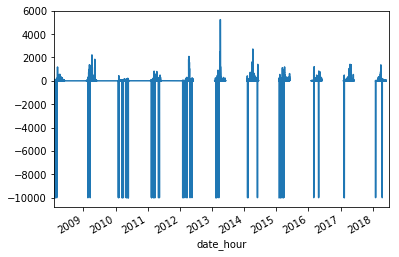

In [41]:
kafun_renamed.京都府立医科大学.plot()

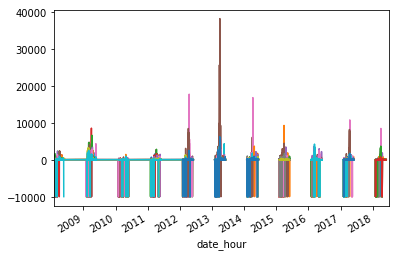

In [42]:
kafun_renamed.plot(legend=False)

In [43]:
kafun_renamed.tail()

,彦根市役所,滋賀県琵琶湖・環境科学研究センター,滋賀県高島県事務所,滋賀県森林センター,京都府立医科大学,京都府中丹東保健所,京都市右京区役所京北合同庁舎,大阪府環境情報センター,豊中市役所第一庁舎,大阪府南河内農と緑の総合事務所 滝畑ダム分室,...,北山緑化植物園,西播磨県民局西播磨総合庁舎,奈良県産業振興総合センター,橿原総合庁舎,和歌山県東牟婁振興局,滋賀県林業普及センター,大阪合同庁舎第2号館別館,彦根地方気象台,舞鶴市西ｺﾐｭﾆﾃｨｾﾝﾀｰ,兵庫県環境研究センター
date_hour,,,,,,,,,,,,,,,,,,,,,
2018-06-30 19:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-06-30 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-06-30 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-06-30 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-06-30 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
